### k-Nearest Neighbor Task

##### 수면 중 스트레스 정도 예측

##### feature
- sr(snoring_rate): 수면 중 코골이의 속도 또는 강도, 어떤 단위 또는 규모로 측정될 수 있습니다  
- rr(respiration_rate): 수면 중 분당 취해진 호흡의 수  
- t(body_temperature): 수면 중 사용자의 체온으로, 섭씨 또는 화씨로 측정될 수 있습니다  
- lm(limb_movement): 수면 중 사지 운동의 속도 또는 강도로, 그 사람이 얼마나 활동적이거나 불안정한지를 나타냅니다  
- bo(blood_oxygen): 수면 중 혈액에 존재하는 산소의 양을 나타내는 혈중 산소 농도입니다  
- rem(eye_movement): 수면 중 안구 운동 활동으로, 수면 중 급격한 안구 운동(REM) 단계를 나타낼 수 있습니다  
- sr.1(sleeping_hours): 특정 수면 시간 동안 잠을 잔 시간입니다  
- hr(heart_rate): 수면 중 분당 심장 박동 수, 전반적인 건강 및 수면의 질과 관련된 필수 생리학적 매개 변수  

##### target
- sl(stress_level): 수면 중 스트레스 정도를 나타내는 목표 변수로 다음과 같이 구분됩니다

In [2]:
import pandas as pd

stress_df = pd.read_csv("./datasets/stress_in_sleep.csv")
stress_df.columns=['snoring_rate', 'respiration_rate', 'body_temperature', 'limb_movement', 'blood_oxygen', \
             'eye_movement', 'sleeping_hours', 'heart_rate', 'stress_level']
stress_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   snoring_rate      630 non-null    float64
 1   respiration_rate  630 non-null    float64
 2   body_temperature  630 non-null    float64
 3   limb_movement     630 non-null    float64
 4   blood_oxygen      630 non-null    float64
 5   eye_movement      630 non-null    float64
 6   sleeping_hours    630 non-null    float64
 7   heart_rate        630 non-null    float64
 8   stress_level      630 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 44.4 KB


In [4]:
stress_df.describe().T

,count,mean,std,min,25%,50%,75%,max
snoring_rate,630.0,71.6,19.372833,45.0,52.50,70.0,91.25,100.0
respiration_rate,630.0,21.8,3.966111,16.0,18.50,21.0,25.00,30.0
body_temperature,630.0,92.8,3.529690,85.0,90.50,93.0,95.50,99.0
limb_movement,630.0,11.7,4.299629,4.0,8.50,11.0,15.75,19.0
blood_oxygen,630.0,90.9,3.902483,82.0,88.50,91.0,94.25,97.0
eye_movement,630.0,88.5,11.893747,60.0,81.25,90.0,98.75,105.0
sleeping_hours,630.0,3.7,3.054572,0.0,0.50,3.5,6.50,9.0
heart_rate,630.0,64.5,9.915277,50.0,56.25,62.5,72.50,85.0
stress_level,630.0,2.0,1.415337,0.0,1.00,2.0,3.00,4.0


In [9]:
stress_df[stress_df['sleeping_hours'] == 0].loc[:, 'stress_level'].value_counts()

stress_level
4    126
3      1
Name: count, dtype: int64

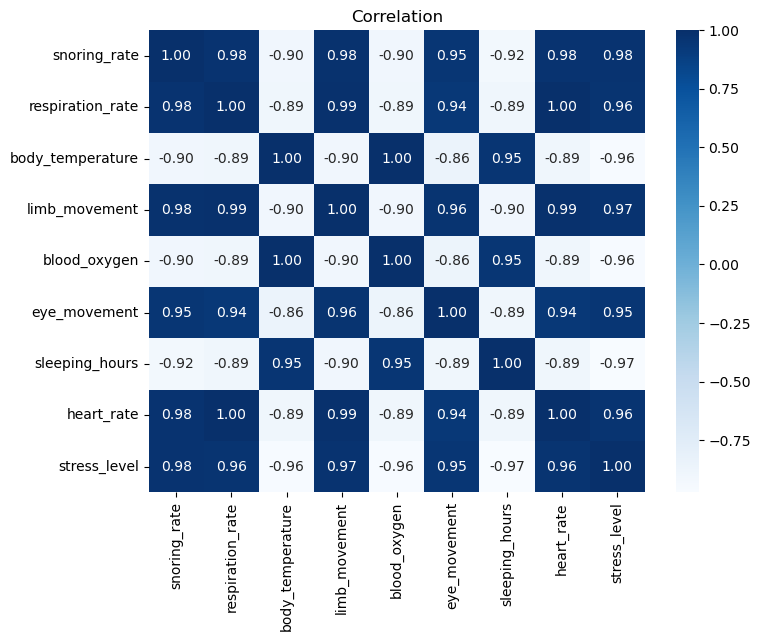

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
correlation_matrix = stress_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", fmt='.2f')
plt.title("Correlation")
plt.show()

In [20]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier

k_neighbors_classifier = KNeighborsClassifier()
grid_knn = GridSearchCV(k_neighbors_classifier, {'n_neighbors': [3, 5, 7]}, cv=3, refit=True, return_train_score=True, n_jobs=4)

In [21]:
from sklearn.model_selection import train_test_split

features, targets = stress_df.iloc[:,:-1], stress_df.stress_level

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, stratify=targets)

grid_knn.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'n_neighbors': [3, 5, 7]}, return_train_score=True)

In [22]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# 타겟 데이터와 예측 객체를 전달받는다.
def get_evaluation(y_test, prediction, classifier=None, X_test=None):
#     오차 행렬
    confusion = confusion_matrix(y_test, prediction)
#     정확도
    accuracy = accuracy_score(y_test , prediction)
#     정밀도
    precision = precision_score(y_test , prediction, average='macro')
#     재현율
    recall = recall_score(y_test , prediction, average='macro')
#     F1 score
    f1 = f1_score(y_test, prediction, average='macro')
#     ROC-AUC
#     roc_auc = roc_auc_score(y_test, prediction)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy , precision ,recall, f1))
    print("#" * 75)
    
    if classifier is not None and  X_test is not None:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]

        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, ax=ax, cmap=plt.cm.Blues, normalize=normalize)
            disp.ax_.set_title(title)
        plt.show()

오차 행렬
[[25  0  0  0  0]
 [ 0 25  0  0  0]
 [ 0  0 25  0  0]
 [ 0  0  0 25  0]
 [ 0  0  0  0 26]]
정확도: 1.0000, 정밀도: 1.0000, 재현율: 1.0000, F1:1.0000
###########################################################################


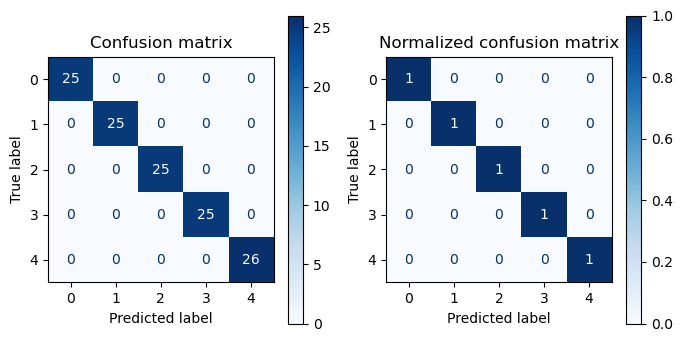

In [23]:
prediction = grid_knn.predict(X_test)
get_evaluation(y_test, prediction, grid_knn, X_test)